# Counting objects, counting objects of different kind, computing amount of fiches with different values

Il progetto  consiste nel costruire un applicativo che addestrato su immagini raffiguranti un gruppo di fiches o monete di differenti forme e/o colori,  restituisca il valore totale , e/o il conteggio differenziale delle fiches presenti in un' immagine test. 

In [8]:
import cv2
from prettytable import PrettyTable
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Check Tensorflow version
print(tf.__version__)
# Check available devices
print("Available devices:", tf.config.list_physical_devices('GPU'))
# Check TensorFlow is using the GPU
print("Is GPU available:", tf.test.is_gpu_available())

2.20.0-rc0
Available devices: []
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: False


In [6]:
def generate_dataset(num_images, image_size=(64, 64), max_objects=10, padding=2):
    """
    Generates a dataset of images with non-overlapping and non-touching shapes (squares, triangles, circles).

    Args:
        num_images: Number of images to generate.
        image_size: Tuple indicating the image dimensions (height, width).
        max_objects: Maximum number of objects in a single image.
        padding: Minimum number of black pixels separating objects.

    Returns:
        images: Generated images as a NumPy array.
        labels: Corresponding labels as a NumPy array in the format:
                [total_objects, num_squares, num_red_squares, num_green_squares, num_blue_squares,
                 num_triangles, num_red_triangles, num_green_triangles, num_blue_triangles,
                 num_circles, num_red_circles, num_green_circles, num_blue_circles,
                 color_value_sum].
    """
    images = []
    labels = []
    colors = {
        "red": (255, 0, 0, 1),   # (BGR color, value)
        "green": (0, 255, 0, 2),
        "blue": (0, 0, 255, 5)
    }
    color_keys = list(colors.keys())  # ["red", "green", "blue"]
    shapes = ["square", "triangle", "circle"]

    for _ in range(num_images):
        img = np.zeros(image_size + (3,), dtype=np.uint8)  # RGB image
        mask = np.zeros(image_size, dtype=np.uint8)  # Mask to track occupied pixels
        num_objects = np.random.randint(1, max_objects + 1)

        # Initialize counts for shapes and colors
        label = [0] * 14  # Placeholder for the label vector
        color_value_sum = 0  # Sum of values of all objects by color
        
        objects_placed = 0  # Track the actual number of placed objects

        for _ in range(num_objects):
            placed = False
            size = np.random.randint(8, 10)  # Object size between 5 and 10
            attempts = 0
            
            # Randomly select a shape and color
            shape = shapes[np.random.randint(len(shapes))]
            color_name = color_keys[objects_placed % len(color_keys)]  # Cycle through colors
            color, color_value = colors[color_name][:3], colors[color_name][3]

            while not placed and attempts < 100:  # Limit to 100 placement attempts
                x = np.random.randint(padding, image_size[0] - size - padding)
                y = np.random.randint(padding, image_size[1] - size - padding)
                
                # Check for separation using the padding
                if np.sum(mask[x - padding:x + size + padding, y - padding:y + size + padding]) == 0:
                    if shape == "square":
                        # Draw a square
                        img[x:x + size, y:y + size] = color
                        mask[x:x + size, y:y + size] = 1
                        label[1] += 1  # Increment square count
                        label[2 + color_keys.index(color_name)] += 1  # Increment specific color count for squares
                    
                    elif shape == "triangle":
                        # Draw a triangle
                        point1 = (y, x)
                        point2 = (y + size, x + size // 2)
                        point3 = (y, x + size)
                        triangle_cnt = np.array([point1, point2, point3])
                        cv2.fillPoly(img, [triangle_cnt], color)
                        cv2.fillPoly(mask, [triangle_cnt], 1)
                        label[5] += 1  # Increment triangle count
                        label[6 + color_keys.index(color_name)] += 1  # Increment specific color count for triangles
                    
                    elif shape == "circle":
                        # Draw a circle
                        center = (y + size // 2, x + size // 2)
                        cv2.circle(img, center, size // 2, color, -1, lineType=cv2.LINE_8)
                        cv2.circle(mask, center, size // 2 + padding, 1, -1)
                        label[9] += 1  # Increment circle count
                        label[10 + color_keys.index(color_name)] += 1  # Increment specific color count for circles
                    
                    placed = True
                    objects_placed += 1
                    color_value_sum += color_value  # Add color value to the sum
                else:
                    attempts += 1

            if attempts >= 100:
                print("Warning: Could not place object after 100 attempts")

        # Finalize the label
        label[0] = objects_placed  # Total number of objects
        label[-1] = color_value_sum  # Sum of color values
        labels.append(label)
        images.append(img)
    
    return np.array(images), np.array(labels)


# Generate training and validation datasets
train_images, train_labels = generate_dataset(10000, max_objects=20, padding=3)
val_images, val_labels = generate_dataset(5000, max_objects=20, padding=3)

# Normalize images to 0-1 range for neural network
train_images = train_images / 255.0
val_images = val_images / 255.0
train_labels = train_labels.astype(np.float32)
val_labels = val_labels.astype(np.float32)

print(train_labels)

[[14.  7.  2. ...  0.  0. 35.]
 [11.  4.  2. ...  2.  1. 27.]
 [ 9.  2.  2. ...  3.  3. 24.]
 ...
 [ 4.  1.  0. ...  0.  0.  9.]
 [ 4.  2.  1. ...  1.  0.  9.]
 [ 2.  1.  1. ...  1.  0.  3.]]


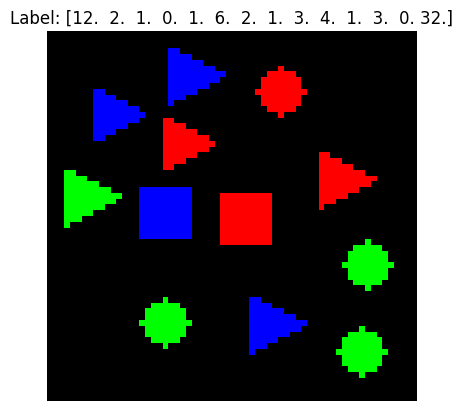

In [10]:
# Check a sample image and its label
plt.imshow(train_images[1])
plt.title(f"Label: {train_labels[1]}")
plt.axis("off")
plt.show()

In [11]:
def precision_score(y_true, y_pred):
    count = 0
    n_samples = len(y_true)
    
    # Check that y_true and y_pred have the same shape
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Iterate through the samples
    for i in range(n_samples):
        if np.array_equal(y_true[i], y_pred[i]):
            count += 1

    return count / n_samples if n_samples > 0 else 0.0  # Avoid division by zero

In [12]:
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.python.keras import Sequential


In [13]:

#from keras.src.layers import Flatten


# Define the CNN model
def create_model2(input_shape, output_dim):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(output_dim, activation='linear')
    ])
    return model


In [14]:
from keras.src.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras import Sequential, Input


# Define the CNN model
def create_model(input_shape, output_dim):
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        # First block: Conv + BatchNorm + ReLU + MaxPool
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Second block: Conv + BatchNorm + ReLU + MaxPool
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Third block: Conv + BatchNorm + ReLU + MaxPool
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Fourth block: Conv + BatchNorm + ReLU + MaxPool
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Fifth block: Global Average Pooling (for reducing the number of parameters)
        GlobalAveragePooling2D(),
        #Flatten(),
        # Dense layer with regularization
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        #Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        # Output layer
        Dense(output_dim, activation='linear')
    ])
    return model

In [15]:
from keras.src.optimizers import Adam

# Create the model
input_shape = train_images.shape[1:]  # (64, 64, 3)
output_dim = train_labels.shape[1]    # 14 (number of label elements)
model = create_model(input_shape, output_dim)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',  # Regression problem
              metrics=['mae'])  # Mean Absolute Error for monitoring

In [16]:
from keras.src.callbacks import ModelCheckpoint

# Filepath to save the best weights
checkpoint_filepath = 'best_model_v4.weights.h5'

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,        # File to save weights
    monitor='val_loss',                  # Metric to monitor
    save_best_only=True,                 # Save only the best weights
    save_weights_only=True,              # Save only weights (not the entire model)
    mode='min',                          # Minimize the monitored metric (e.g., loss)
    verbose=1                            # Print messages when weights are saved
)

In [17]:
# Train the model
history = model.fit(train_images, train_labels, 
                    validation_data=(val_images, val_labels), 
                    epochs=30, 
                    batch_size=32,
                    callbacks=[checkpoint_callback])

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.0405 - mae: 1.1775
Epoch 1: val_loss improved from None to 41.62311, saving model to best_model_v4.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - loss: 2.0894 - mae: 0.9152 - val_loss: 41.6231 - val_mae: 3.0063
Epoch 2/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1831 - mae: 0.8061
Epoch 2: val_loss improved from 41.62311 to 1.08101, saving model to best_model_v4.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - loss: 1.0597 - mae: 0.7640 - val_loss: 1.0810 - val_mae: 0.7603
Epoch 3/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.7265 - mae: 0.6315
Epoch 3: val_loss improved from 1.08101 to 0.82258, saving model to best_model_v4.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - loss: 0.6721 - mae: 0.6015 - val_loss: 0.8226 - val_mae: 0.6784
Epoch 4/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4407 - mae: 0.4694
Epoch 4: val_loss improved from 0.82258 to 0.41103, saving model t

In [18]:
# Load the best weights after training
model.load_weights(checkpoint_filepath)
print("Best weights loaded into the model.")

Best weights loaded into the model.


In [19]:
# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(val_images, val_labels)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0275 - mae: 0.1206
Validation Loss: 0.027543511241674423, Validation MAE: 0.12060854583978653


In [20]:
# Save the model
#model.save("shape_recognition_model.keras")

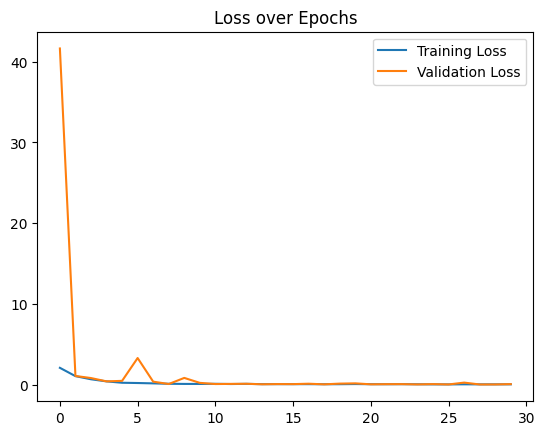

In [21]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

In [22]:
# Test the model on a new dataset
test_images, test_labels = generate_dataset(1000, max_objects=20, padding=3)
test_images = test_images / 255.0
test_labels = test_labels.astype(np.float32)

In [23]:

# Predict with the trained model
predictions = model.predict(test_images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [24]:
label_meanings = [
    "Total objects",
    "Total squares", "Red squares", "Green squares", "Blue squares",
    "Total triangles", "Red triangles", "Green triangles", "Blue triangles",
    "Total circles", "Red circles", "Green circles", "Blue circles",
    "Value"
]

def print_labels_table(actual_label, predicted_label, num):
    table = PrettyTable()
    table.field_names = [f"Image {num}", "Target", "Prediction"]
    for i, meaning in enumerate(label_meanings):
        table.add_row([meaning, f"{actual_label[i]:.2f}", f"{predicted_label[i]:.2f}"])
    print(table)

+-----------------+--------+------------+
|     Image 0     | Target | Prediction |
+-----------------+--------+------------+
|  Total objects  | 13.00  |   13.00    |
|  Total squares  |  5.00  |    5.00    |
|   Red squares   |  4.00  |    4.00    |
|  Green squares  |  1.00  |    1.00    |
|   Blue squares  |  0.00  |    0.00    |
| Total triangles |  6.00  |    6.00    |
|  Red triangles  |  1.00  |    1.00    |
| Green triangles |  2.00  |    2.00    |
|  Blue triangles |  3.00  |    3.00    |
|  Total circles  |  2.00  |    2.00    |
|   Red circles   |  0.00  |   -0.00    |
|  Green circles  |  1.00  |    1.00    |
|   Blue circles  |  1.00  |    1.00    |
|      Value      | 33.00  |   33.00    |
+-----------------+--------+------------+


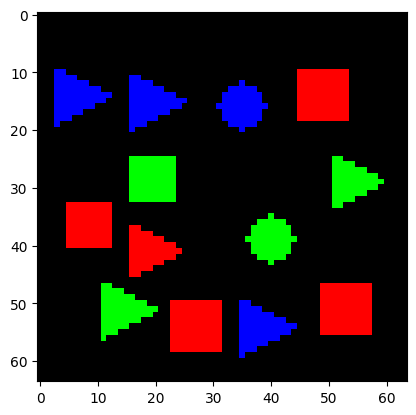

+-----------------+--------+------------+
|     Image 1     | Target | Prediction |
+-----------------+--------+------------+
|  Total objects  | 10.00  |   10.00    |
|  Total squares  |  4.00  |    4.00    |
|   Red squares   |  1.00  |    1.00    |
|  Green squares  |  2.00  |    2.00    |
|   Blue squares  |  1.00  |    1.00    |
| Total triangles |  3.00  |    3.00    |
|  Red triangles  |  2.00  |    2.00    |
| Green triangles |  0.00  |   -0.00    |
|  Blue triangles |  1.00  |    1.00    |
|  Total circles  |  3.00  |    3.00    |
|   Red circles   |  1.00  |    1.00    |
|  Green circles  |  1.00  |    1.00    |
|   Blue circles  |  1.00  |    1.00    |
|      Value      | 25.00  |   25.00    |
+-----------------+--------+------------+


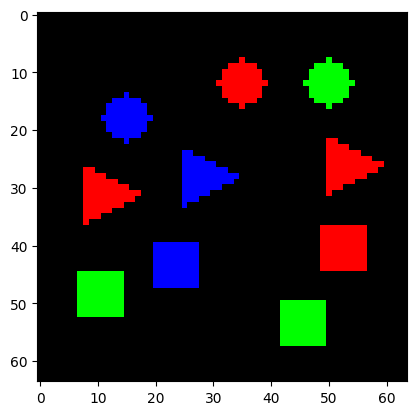

+-----------------+--------+------------+
|     Image 2     | Target | Prediction |
+-----------------+--------+------------+
|  Total objects  | 14.00  |   14.00    |
|  Total squares  |  7.00  |    7.00    |
|   Red squares   |  2.00  |    2.00    |
|  Green squares  |  2.00  |    2.00    |
|   Blue squares  |  3.00  |    3.00    |
| Total triangles |  5.00  |    5.00    |
|  Red triangles  |  2.00  |    2.00    |
| Green triangles |  3.00  |    3.00    |
|  Blue triangles |  0.00  |    0.00    |
|  Total circles  |  2.00  |    2.00    |
|   Red circles   |  1.00  |    1.00    |
|  Green circles  |  0.00  |    0.00    |
|   Blue circles  |  1.00  |    1.00    |
|      Value      | 35.00  |   35.00    |
+-----------------+--------+------------+


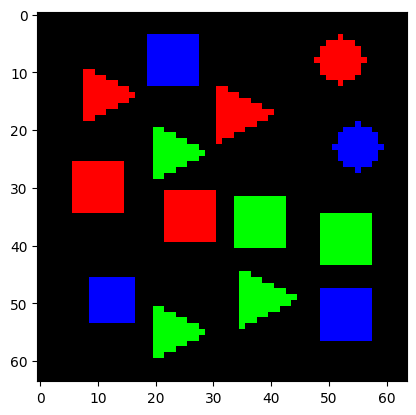

+-----------------+--------+------------+
|     Image 3     | Target | Prediction |
+-----------------+--------+------------+
|  Total objects  |  2.00  |    2.00    |
|  Total squares  |  1.00  |    1.00    |
|   Red squares   |  0.00  |   -0.00    |
|  Green squares  |  1.00  |    1.00    |
|   Blue squares  |  0.00  |   -0.00    |
| Total triangles |  0.00  |    0.00    |
|  Red triangles  |  0.00  |    0.00    |
| Green triangles |  0.00  |   -0.00    |
|  Blue triangles |  0.00  |    0.00    |
|  Total circles  |  1.00  |    1.00    |
|   Red circles   |  1.00  |    1.00    |
|  Green circles  |  0.00  |   -0.00    |
|   Blue circles  |  0.00  |   -0.00    |
|      Value      |  3.00  |    3.00    |
+-----------------+--------+------------+


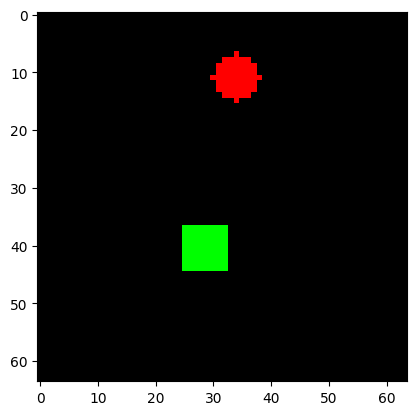

+-----------------+--------+------------+
|     Image 4     | Target | Prediction |
+-----------------+--------+------------+
|  Total objects  | 13.00  |   13.00    |
|  Total squares  |  4.00  |    4.00    |
|   Red squares   |  1.00  |    1.00    |
|  Green squares  |  2.00  |    2.00    |
|   Blue squares  |  1.00  |    1.00    |
| Total triangles |  3.00  |    3.00    |
|  Red triangles  |  1.00  |    1.00    |
| Green triangles |  0.00  |   -0.00    |
|  Blue triangles |  2.00  |    2.00    |
|  Total circles  |  6.00  |    6.00    |
|   Red circles   |  3.00  |    3.00    |
|  Green circles  |  2.00  |    2.00    |
|   Blue circles  |  1.00  |    1.00    |
|      Value      | 33.00  |   34.00    |
+-----------------+--------+------------+


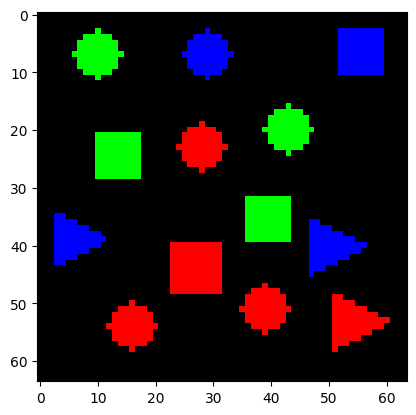

In [25]:
# Display predictions
for i in range(5):
    print_labels_table(test_labels[i], np.round(predictions[i]), i)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.show()

In [26]:
predictions_rounded = np.round(predictions).astype(int)
score = precision_score(test_labels, predictions_rounded)
print(f"Precision Score: {score}")
print(f"Correctly Predicted: {round(score * len(test_labels))} over {len(test_labels)}")

Precision Score: 0.855
Correctly Predicted: 855 over 1000
